# Intro to AI-driven Science on Supercomputers

## Week 1 Homework

#### Dan Horner (danhorner@berkeley.edu)
---

# Clustering Data with Machine Learning

## Package imports

In [1]:
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time
import IPython.display as ipydis

# Imports for some data manipulation and plotting
import pandas as pd
from plotnine import *
import plotnine as p9
p9.options.figure_size = (9, 6)

np.random.seed(1)

## Function definitions

In [2]:

def plot_clust(x, labels, centers, N, centroids_hist = None):
    # Function for plotting the labeled points and the initial cluster centers, and optionally the centroid "track" from the k-means fitting 
    df0 = pd.DataFrame(x).rename(columns = {0: 'x', 1: 'y'})
    df0['label'] = labels.astype(str)
    
    df1 = pd.DataFrame(centers).rename(columns = {0: 'x', 1: 'y'})

    pl = (ggplot()
          + geom_point(df0, aes(x = 'x', y = 'y', colour = 'label'), size = 1.1, fill = 'white')
          + scale_x_continuous(name = ' ', breaks = np.arange(-10, 10, 2))
          + scale_y_continuous(name = ' ', breaks = np.arange(-10, 10, 2))
          + ggtitle('')
          + coord_fixed()
          + theme(
              legend_position="none",
          )
         )
     
    if centroids_hist is not None:
        
        df2 = pd.DataFrame(centroids_hist).rename(columns = {0: 'x', 1: 'y'})
        df2['label'] = list(range(N)) * int(len(df2.index) / N)
        df2['label'] = df2['label'].astype(str)

        df3 = df2.groupby('label').head(1)
        df4 = df2.groupby('label').tail(1)

        pl = (pl 
              + geom_line(df2, aes(x = 'x', y = 'y', colour = 'label'))
              + geom_point(df2, aes(x = 'x', y = 'y', colour = 'label'))
              + geom_point(df3,  aes(x = 'x', y = 'y', fill = 'label'), colour = 'black', size = 4, shape = 's')
              + geom_point(df4,  aes(x = 'x', y = 'y', fill = 'label'), colour = 'black', size = 4)
             )
    
    
    pl = pl + geom_point(df1, aes(x = 'x', y = 'y'), shape = 'x', colour = 'darkred', size = 4)

    return(pl)



In [3]:
def initialize_centroids(x,N):
    x_indices = np.random.choice(np.arange(0,x.shape[0]),N)
    centroids = x[x_indices]
    return centroids

def get_new_centroids(x, labels, N):
    """returns the new centroids assigned from the points closest to them"""
    return np.array([x[labels==k].mean(axis=0) for k in range(N)])
    

In [4]:
# distance is sqrt( (x - x')**2 + (y - y')**2 )
def assign_labels(x,c):
    # centroids are shape [N,2]
    # x are shape [npoints,2]
    # add middle index to centroids to properly broadcast in math operations
    c = c[:,np.newaxis,:] # [N,1,2]
   
    # calculate (x - x')**2 and (y - y')**2
    # x is shape [npoints,2], c is [N,1,2] results in an array of shape: [N,npoints,2]
    dist2 = (x - c)**2
   
    # calculate (x - x')**2 + (y - y')**2
    dist2 = dist2.sum(axis=2) # [N,npoints]
   
    # out of the N distances, return the index (0-(N-1)) of the one that is the minimum.
    label = np.argmin(dist2,axis=0) # [npoints]

    return label

## Fitting process

In [5]:
# Parameters
npoints = 4000
N = 4
delta = 0.01
loop_N = 100

#Initial cluster set-up
x, cluster_labels, cluster_centers = make_blobs(n_samples=npoints, centers=N,
                       cluster_std=0.7, random_state=0,
                       return_centers=True)

# Initialize centroids
last_centroids = initialize_centroids(x,N)
last_labels = assign_labels(x,last_centroids)
# Centroid "track" for plotting after fitting
centroids_hist = last_centroids 

done = False
for step in range(loop_N):
    
    centroids = get_new_centroids(x,last_labels,N)
    labels = assign_labels(x,centroids)
    
    # test if centroids have stopped moving
    if np.all(np.abs(last_centroids - centroids) < delta):
        print('Stopping: centroids unchanged as of step %d' % step)
        done = True
    elif np.all(labels == last_labels):
        print('Stopping: point labels unchanged as of step %d' % step)
        done = True
    else:
        last_labels = labels
        last_centroids = centroids
        centroids_hist = np.concatenate((centroids_hist, last_centroids), axis = 0)
    
    if done is True:
        break
if done is False:
    print('Stopping: Max iterations reached: %d' % (step + 1))


Stopping: point labels unchanged as of step 4


## Charts

In the charts below I have plotted the data points labeled by color and the cluster centers passed to `make_blobs` as red $\times$'s

The first figure shows just the points with their initial cluster labels and the cluster centers.

The second figure shows data points and the cluster centers as well as the centroid "tracks"; their initial (random) positions as $\square$'s, their final fitted positions as $\bigcirc$'s, and their position after each step as dots. In this figure the points and tracks are colored by the final k-means cluster they belong to (i.e., which centroid they are closest to).

Note that the actual labels (i.e., colors) associated with each cluster are completely arbitrary and there is no correspondence between the two plots. However, if we assume that the points returned by `make_blobs` are truly centered around the `cluster_centers`, the final centroids should end up being quite close to the cluster centers. 

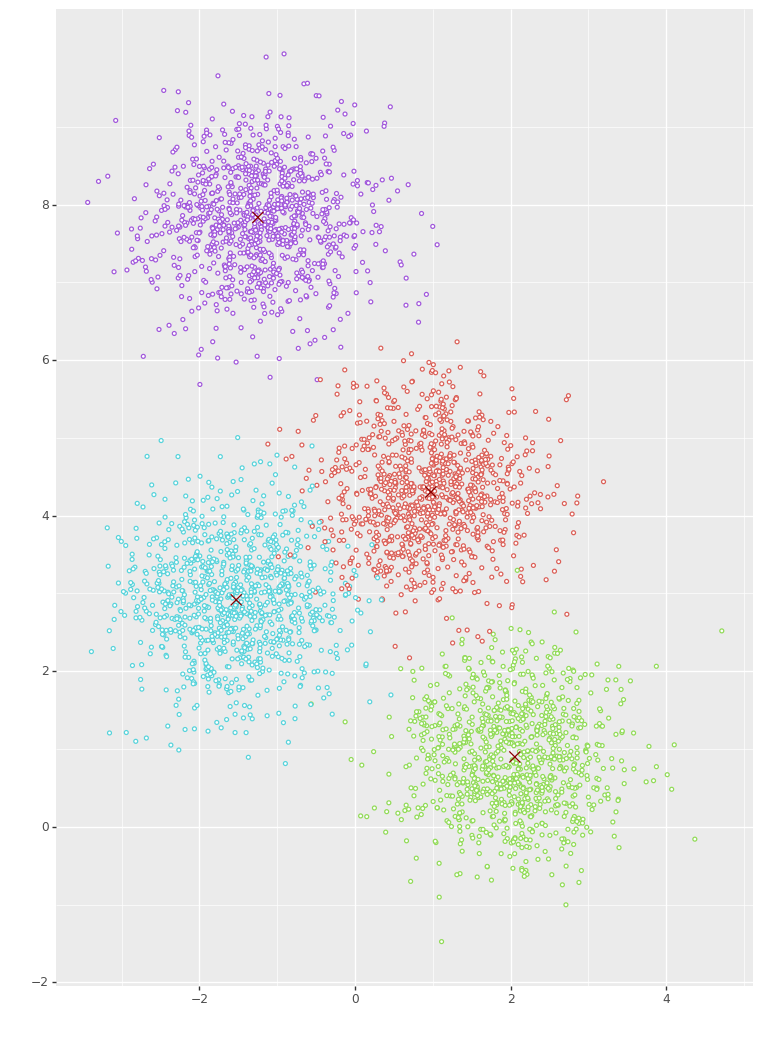

In [6]:
# Plot of points, cluster centers (X) and initial labels
print(plot_clust(x, cluster_labels, cluster_centers, N))

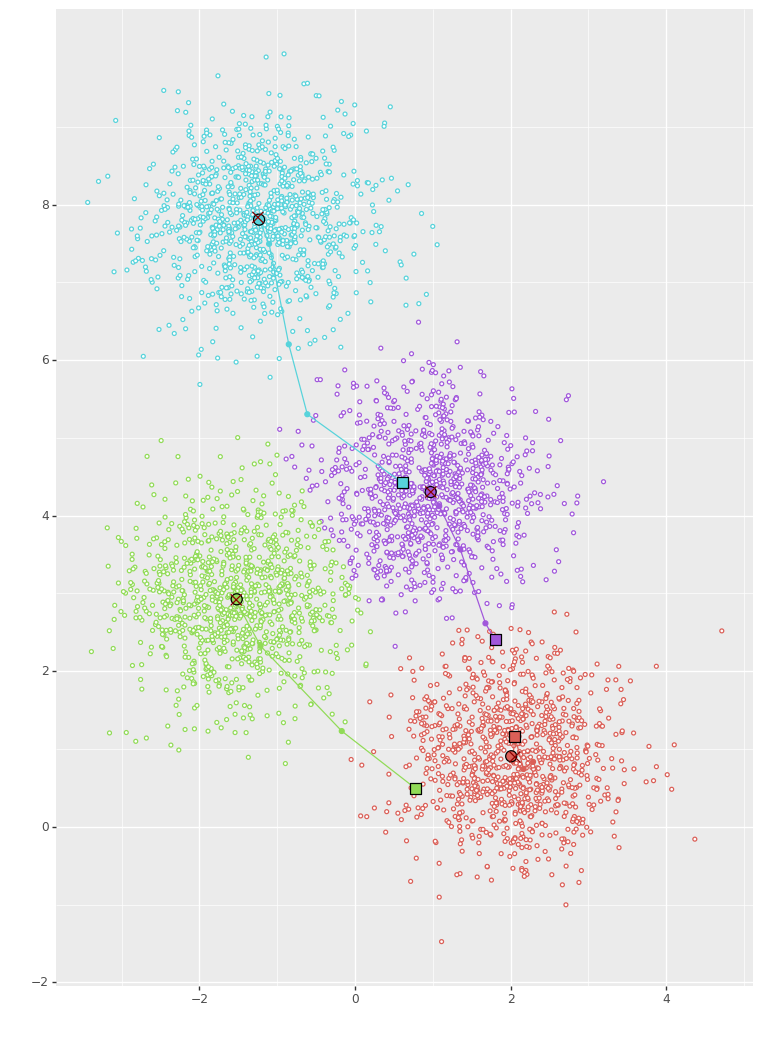

In [7]:
# Plot of points and cluster centers (X) with k-means labels and the centroid "track" 
# Square (initial centroid postition) to Circle (final centroid position)

print(plot_clust(x, labels, cluster_centers, N, centroids_hist))

## Metrics

K-means is a clustering algorithm, NOT a classification algorithm; however, it may be useful to consider how we could evaluate the goodneess of our clustering.
In this particular example, we have some information that we use: cluster centers and initail cluster labels. 

- While the clusters are random and the `cluster_centers` may not be the exact 'center' of its points, it is reasonable to assume that we would want our centroids to be close to those cluster centers and a small distance between the centroids and the cluster centers would be best.

- The previous metric relies somewhat on the assumption that the clusters are distributed around a known point. If we think just in terms of clustering not distances, we would reasonably expect that a good clustering should have points from the same initial (labled) cluster be in the same k-means cluster (assuming that individual clusters don't overlap *too much*.)

### RMS distance

Since there is not correspondance between the arbitrary ordering of the points in `cluster_centers` and the final centroids, I order then based on their *y* values (assuming that will lead to the *same* ordering between the two sets of points. The better, but potentially much more complicated approach would be to determine the cluster center each centroid is clostest to; and ensure that there is a 1-1 correspondance$-$I did not do that here: I chose the straightforward approach.

Once the points have the same ordering we can compute the root-mean-square error

In [8]:
#RMS distance between final centroids and the initial cluster centers

c1 = cluster_centers[cluster_centers[:, 1].argsort()]
c2 = centroids[centroids[:, 1].argsort()]
rmse = np.sqrt(np.square(c1 - c2).mean()) 


print('Cluster centers')
print(c1.round(4))
print()
print('Centroids')
print(c2.round(4))
print()
print('RMSE')
print(rmse.round(4))

Cluster centers
[[ 2.0553  0.8977]
 [-1.5269  2.9179]
 [ 0.9763  4.3038]
 [-1.2483  7.8355]]

Centroids
[[ 2.0078  0.9099]
 [-1.5242  2.9195]
 [ 0.9607  4.3155]
 [-1.2391  7.8154]]

RMSE
0.0202


### Cluster accuracy

If we wish to determine how well the clustering does we can compute how well points in the same initial cluster are labeled as the same cluster by k-means. Again, the acutal initial and k-means labels are completely arbitrary and do correspond to each other. However, if we reasonably assume that points in the same initial cluster would be most often in the same k-means cluster and most points in each k-means cluster come from the same initial cluster we can compute the accuracy.

We first start with the confusion matrix (how many points of each initial cluster (rows) were labeled as each k-means cluster (columns)). Assuming the greatest value in each row/column represents the initial and k-means cluster correspondance, we can computer the accuracy (in this case it is the micro-average precision/micro-averag recall.) 

In [9]:

cm = confusion_matrix(cluster_labels, labels)

tp = cm.max(axis = 0)
fp = (cm.sum(axis = 0) - cm.max(axis = 0))
fn = (cm.sum(axis = 1) - cm.max(axis = 1))

acc = np.round(tp.sum() / (tp.sum() + fp.sum()), 3)

print('Confusion Matrix')
print(cm)
print()
print('True, Positives:')
print(tp)
print('False Positives:')
print(fp)
print('False Negatives:')
print(fn)
print()
print('Accuracy')
print(acc)


Confusion Matrix
[[  8  16   0 976]
 [996   2   0   2]
 [  2 987   0  11]
 [  0   0 998   2]]

True, Positives:
[996 987 998 976]
False Positives:
[10 18  0 15]
False Negatives:
[24  4 13  2]

Accuracy
0.989
